<a href="https://colab.research.google.com/github/glorivaas/Machine_Learning25/blob/main/Lab10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 10 - Convolutional Neural Network, CNN

### Author: Szymon Nowakowski

# Presentation on Convolutional Layers
--------------------

We shall start off by going through a [short presentation on convolusional layers](https://github.com/SzymonNowakowski/Machine-Learning-2024/blob/master/convolutional_layers.pdf). It is best to first download it and then go through it in a slide-show layout.

# Reading MNIST Dataset
----------------------------------

In [1]:
import torch
import torchvision
from matplotlib import pyplot

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.84MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.20MB/s]


# Tensor Sizes
-------------------

Recall:
- Batched labels are of order one. The first (and only) index is a sample index within a batch.
- Image batches have order 4. The first order is a batch order, but a second order has dimensionality of 1 and thus it can be indexed by 0 only.
  - This index represents a Channel number inserted here by `ToTensor()` transformation, always 0.
  - This singleton order should be retained because we want to use convolutional layers, which explicitly require this order. For RGB images we have 3 channels, for B&W images we have only one channel.


# CNN Definition
-----------------



## Task

Your job now is to code the definition of the LeNet5 neural network. You can find the definition [here](https://en.wikipedia.org/wiki/LeNet#/media/File:Comparison_image_neural_networks.svg).


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.dropout = nn.Dropout(0.05)

    def forward(self, x):
        x = F.sigmoid(self.conv1(x))
        x = self.pool1(x)

        x = F.sigmoid(self.conv2(x))
        x = self.pool2(x)

        x = x.view(-1, 16 * 5 * 5)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)

        x = self.dropout(x)
        return x


# Training Loop
----------------------

In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = LeNet5().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(16):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the LeNet5 object. Please note,
                                            # the nonlinear activation after the last layer is NOT applied
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cuda
epoch: 0 batch: 0 current batch loss: 2.3307855129241943
epoch: 0 batch: 1 current batch loss: 2.3147192001342773
epoch: 0 batch: 2 current batch loss: 2.3094217777252197
epoch: 0 batch: 3 current batch loss: 2.302011728286743
epoch: 0 batch: 4 current batch loss: 2.3008713722229004
epoch: 0 batch: 5 current batch loss: 2.301276922225952
epoch: 0 batch: 6 current batch loss: 2.3053061962127686
epoch: 0 batch: 7 current batch loss: 2.305540084838867
epoch: 0 batch: 8 current batch loss: 2.305358648300171
epoch: 0 batch: 9 current batch loss: 2.3026819229125977
epoch: 0 batch: 10 current batch loss: 2.29953670501709
epoch: 0 batch: 11 current batch loss: 2.3063771724700928
epoch: 0 batch: 12 current batch loss: 2.3060097694396973
epoch: 0 batch: 13 current batch loss: 2.3032724857330322
epoch: 0 batch: 14 current batch loss: 2.302356004714966
epoch: 0 batch: 15 current batch loss: 2.3019044399261475
epoch: 0 batch: 16 current batch loss: 2.3013837337493896
epoch: 0 batch:

# Testing
----------------------

In [4]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9386


# Understanding Kernel Size, Stride and Padding

## Task: Designing a Convolutional Neural Network with a Target Receptive Field

Design a convolutional neural network using only 3×3 or 5×5 convolutional layers and 2×2 max-pooling layers without overlap (i.e., with stride 2). Use no padding in any layer. Insert a max-pooling layer after every two or three convolutional layers.

Your goal is to construct an architecture such that the receptive field of each output neuron is approximately 60×60 pixels.

Compute the receptive field size of the final output layer.

Compute the effective stride of the output layer with respect to the input.

Assuming an input image size of 400×400, determine the spatial size of the output feature map.

Q: Where would you locate ReLU layers?
Q: What if we can't match the desired input size with our architecture?
Q: Discuss what possible impact padding can have on the network performance.



In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ReceptiveFieldCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1)     # 400 -> 398
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)    # 398 -> 396
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)         # 396 -> 198

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)    # 198 -> 196
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1)   # 196 -> 194
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)         # 194 -> 97

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1)  # 97 -> 95
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1)  # 95 -> 93
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)         # 93 -> 46

        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, stride=1)  # 46 -> 44
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1)  # 44 -> 42

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 42 * 42, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)  # example: 10 output classes
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool3(x)

        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))

        x = self.classifier(x)
        return x

model = ReceptiveFieldCNN()
dummy_input = torch.randn(1, 3, 400, 400)
output = model(dummy_input)
print("Output shape:", output.shape)


Output shape: torch.Size([1, 10])


- Where would you place ReLU layers?

  After every convolution layer.

- What if we can’t match the desired input size with our architecture?

 We can:

 - Add padding to preserve spatial dimensions (not allowed here).

 - Use interpolation (e.g., resizing input).

 - Add extra conv or pool layers carefully to refine receptive field or output size.



- What’s the impact of padding?

 - Preserves feature map size.
 - Allows deeper networks.
 - Helps edges be processed.
 - Smoother receptive field growth.

# **Homework Assignment – Adversarial Examples**

In this assignment, you will explore how small (invisible to humans) changes to real digits can _fool_ the CNN into misclassifying them, even though the changes are imperceptible to humans.



## Task 1 – CNN Dreams: Last Homework Assignment Revisited

Re-run the input optimization process (for NN dreams) from the previous MLP-class homework assignment, but this time using the **LeNet-5 CNN model** we trained in this class.


1. Starting from ten random noise images, optimize the input so that each image is classified with high confidence as one of the digits 0 through 9.
2. Include an **L2 penalty** on the input to keep the images visually closer to realistic digits. Use a range of penalty strengths (e.g., $\lambda_{l2}$ = 0, and then 0.01 through 10.0).
3. Compare the generated images (with and without L2 penalty) to those generated by the MLP:
   - Are they more or less readable?
   - Do they resemble real MNIST digits more closely or less?
   - Why do you think that happens? Consider the CNN’s inductive biases and architectural properties.

Use `cross_entropy_loss + lambda_l2 * input.pow(2).mean()` as your objective.

Reuse your code: visualize confidence evolution during optimization and generate image grids and (optionally) animations showing how the inputs evolve.


## Task 2 – Adversarial Examples: Fooling LeNet-5

This is the core focus of the assignment.

Using a batch of **real MNIST digits** (e.g., nine examples per class), craft **adversarial examples** by adding subtle, trained noise to the input images. Your goal is to:

- **Keep the human-perceived digit the same** (e.g., a "7" should still look like a "7"),
- But **cause LeNet-5 to misclassify it** – as every other class different from the original, hence nine examples per class.

### Objective
For each image $x$ and its true label $y$, learn a perturbation $\delta$ such that:

- $\text{LeNet5}(x + \delta) = y_{\text{wrong}} $,
- and $ \|\delta\|_2 $ is as small as possible (penalize large perturbations), to keep $x + \delta$ *look* like $x$ for humans.

### Optimization
Use gradient-based optimization on $\delta$ (the noise), while keeping the network weights frozen. Your loss might look like:

```
loss = cross_entropy(model(x + delta), target_wrong_class) +
       lambda_l2 * delta.pow(2).mean()
```

Tune the $\lambda_{l2}$ to find the best range.

### Deliverables for the Second Task
- Select some best examples, showing the original digit and its (correct) classification and the perturbed digit (hopefully, still looking the same to humans) and how it gets misclassified. Show them side by side.
- Report:
  - Success rate of attacks (it doesn't need to be very formal),
  - Effect of $\lambda_{l2}$ on visibility of the noise and success of misclassification,
  - Example image grids and confidence plots.



## Deliverables for the Homework Assignment
- A Google Colab notebook with:
  - Complete implementation for both tasks.
  - Visualizations and animations (animations are optional but encouraged).
  - Clear written analysis of your findings.
- Upload the notebook and results to your GitHub repository for the course.
- Include a link to the notebook and video (if applicable) in the `README.md`.
- In the notebook, include “Open in Colab” badge so it can be launched directly.

# **TASK 1**


Optimizing with λ = 0.0

Optimizing with λ = 0.01

Optimizing with λ = 0.1

Optimizing with λ = 1.0

Optimizing with λ = 10.0


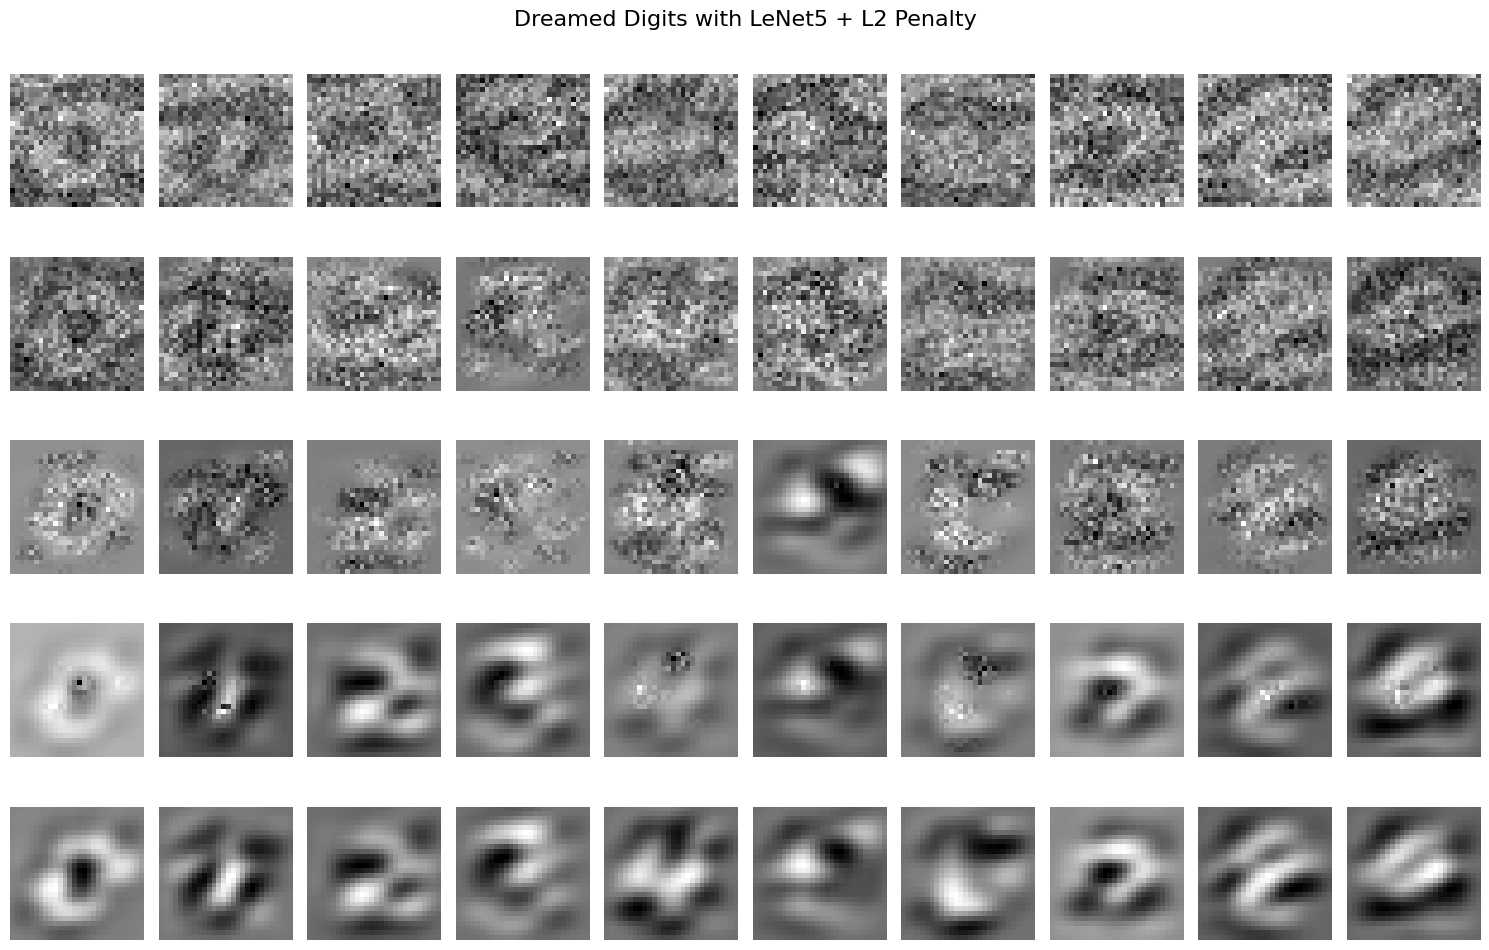

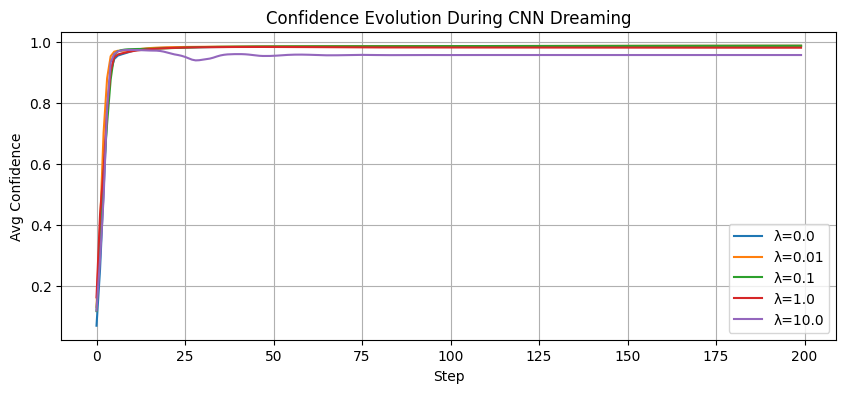

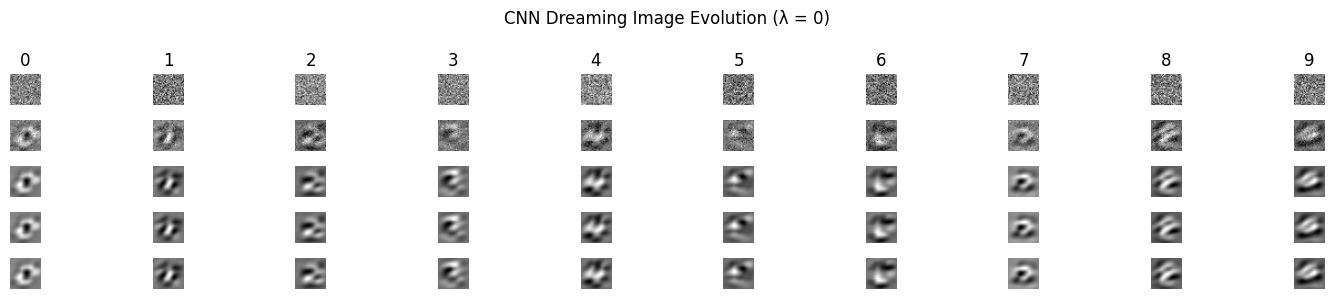

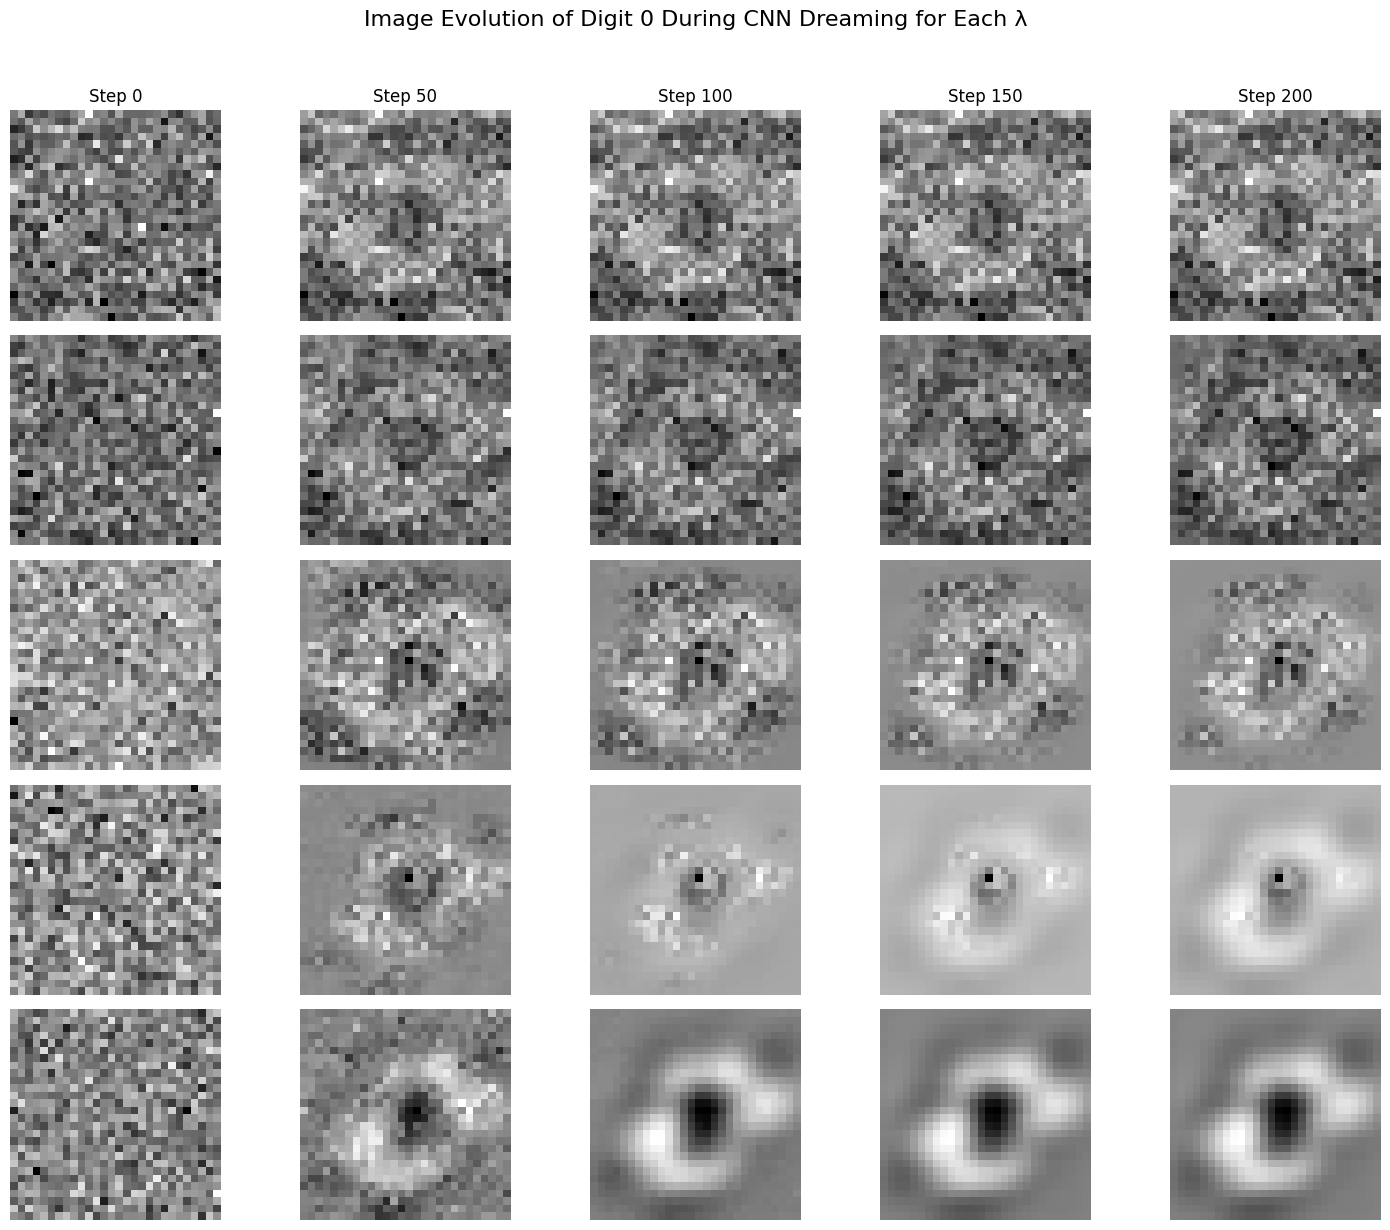

In [6]:
import matplotlib.pyplot as plt

model = net
model.eval()

lambda_values = [0.0, 0.01, 0.1, 1.0, 10.0]
target_labels = torch.arange(10, device=device)

final_results = {}
confidence_progress = {}
snapshots_all = {}

for lambda_l2 in lambda_values:
    print(f"\nOptimizing with λ = {lambda_l2}")
    images = torch.randn(10, 1, 28, 28, device=device, requires_grad=True)
    optimizer = torch.optim.Adam([images], lr=0.1)

    conf_history = []
    snapshots = []

    for step in range(200):
        optimizer.zero_grad()
        logits = model(images)
        loss_ce = F.cross_entropy(logits, target_labels)
        loss = loss_ce + lambda_l2 * images.pow(2).mean()

        probs = F.softmax(logits, dim=1)
        conf = probs[torch.arange(10), target_labels].mean().item()
        conf_history.append(conf)

        loss.backward()
        optimizer.step()

        if step % 50 == 0 or step == 199:
            snapshots.append(images.detach().cpu().clone())

        if conf > 0.99:
            print(f"Early stop at step {step} | Avg Confidence: {conf:.3f}")
            break

    final_results[lambda_l2] = images.detach().cpu()
    confidence_progress[lambda_l2] = conf_history
    snapshots_all[lambda_l2] = snapshots

fig, axes = plt.subplots(len(lambda_values), 10, figsize=(15, len(lambda_values)*2))
for i, lam in enumerate(lambda_values):
    for j in range(10):
        axes[i, j].imshow(final_results[lam][j].squeeze(), cmap='gray')
        axes[i, j].axis('off')
    axes[i, 0].set_ylabel(f"λ={lam}", fontsize=12)
plt.suptitle("Dreamed Digits with LeNet5 + L2 Penalty", fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for lam in lambda_values:
    plt.plot(confidence_progress[lam], label=f"λ={lam}")
plt.xlabel("Step")
plt.ylabel("Avg Confidence")
plt.title("Confidence Evolution During CNN Dreaming")
plt.legend()
plt.grid(True)
plt.show()

n_snapshots = len(snapshots)
fig, axes = plt.subplots(n_snapshots, 10, figsize=(15, 3))
for row, snap in enumerate(snapshots):
    for col in range(10):
        axes[row, col].imshow(snap[col].squeeze(), cmap='gray')
        axes[row, col].axis('off')
        if row == 0:
            axes[row, col].set_title(f"{col}")
        if col == 0:
            axes[row, col].set_ylabel(f"Step {row * 50}", fontsize=10)
plt.suptitle("CNN Dreaming Image Evolution (λ = 0)")
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(len(lambda_values), len(snapshots_all[lambda_values[0]]), figsize=(15, 2.5 * len(lambda_values)))

for row, lam in enumerate(lambda_values):
    for col, snap in enumerate(snapshots_all[lam]):
        img = snap[0].squeeze().numpy()  # Digit 0
        ax = axes[row][col] if len(lambda_values) > 1 else axes[col]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        if row == 0:
            ax.set_title(f"Step {col*50}")
        if col == 0:
            ax.set_ylabel(f"λ = {lam}", fontsize=12)

plt.suptitle("Image Evolution of Digit 0 During CNN Dreaming for Each λ", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

#**ANALYSIS**
- All lines quickdly rise toward confidence (1.0),in the first 25–50 steps.

- Even with stronger L2 penalties (like λ = 10.0), the CNN is still able to confidently classify the dreamed inputs.

- The penalty slows down optimization (as seen in the purple line), but convergence still happens quite fast.

This makes sense as CNNs naturally learn features like edges, textures, and patterns, which help even noisy inputs evolve into confidently classifiable forms.

Futhermore the larger λ, the more "realistic" (smoother) the image is forced to be, but even with regularization, the model is able to reach confident classifications.

#**VISUAL COMPARATION**
- CNN :

 The evolved images become significantly more structured and recognizable, especially with moderate L2 penalties (e.g., λ = 0.1, 1.0). Moreover, final digits show strong resemblance to actual MNIST digits, smooth strokes, centered shapes, and less noise. Even at higher λ values, the digits remain interpretable due to CNN's spatial inductive biases.

- MLP:

 The images remain more noisy and less coherent. Even with low L2 penalties, digits are not clearly distinguishable.

In conclusion the CNN-generated images are more readable than the MLP-generated ones. On top of that, CNN ones resemble real MNIST digits more closely. This is due to the architecture of this new method such as local receptive fields (convolutional filters detect edges and shapes), weight sharing (helps detect patterns regardless of position) and hierarchical feature learning (builds digits from low-level features like edges to high-level shapes).

###Animation

Animation saved as cnn_digit_dreaming_animation.mp4


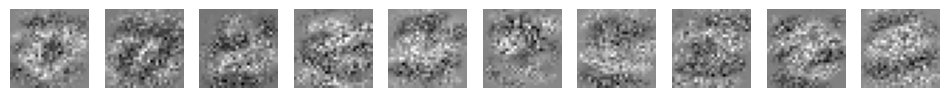

In [7]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.animation as animation

model = net.to("cpu")
model.eval()

lambda_l2 = 0.1
target_labels = torch.arange(10)

images = torch.randn(10, 1, 28, 28, requires_grad=True)
optimizer = torch.optim.Adam([images], lr=0.1)

snapshots = []

for step in range(100):
    optimizer.zero_grad()
    logits = model(images)
    loss = F.cross_entropy(logits, target_labels) + lambda_l2 * images.pow(2).mean()
    loss.backward()
    optimizer.step()

    if step % 10 == 0 or step == 99:
        snapshots.append(images.detach().clone())

fig, axes = plt.subplots(1, 10, figsize=(12, 2))
ims = []

for snapshot in snapshots:
    img_list = []
    for i, ax in enumerate(axes):
        im = ax.imshow(snapshot[i][0], cmap='gray', animated=True)
        ax.axis('off')
        img_list.append(im)
    ims.append(img_list)

ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True)
ani.save("cnn_digit_dreaming_animation.mp4", writer='ffmpeg')

print("Animation saved as cnn_digit_dreaming_animation.mp4")


# **TASK 2**


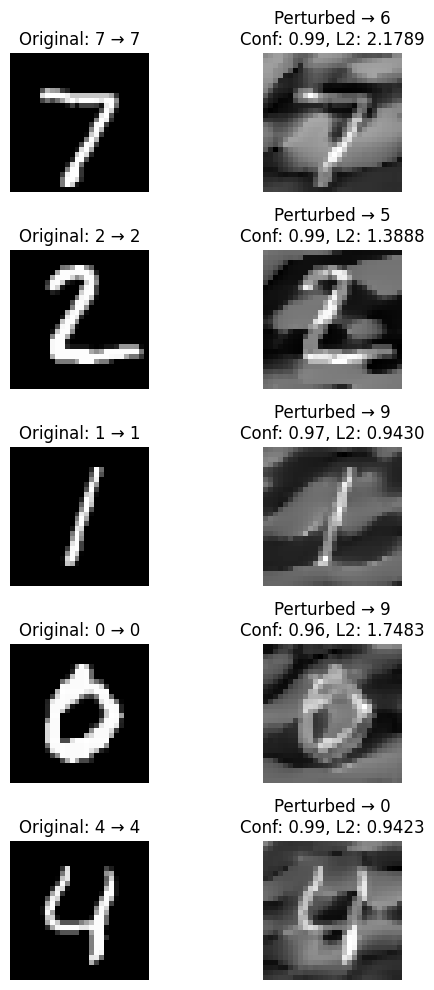

In [12]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
import random

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
mnist = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

samples = {}
for img, label in mnist:
    if label not in samples:
        samples[label] = img.unsqueeze(0)
    if len(samples) == 5:
        break

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
net.eval()

results = []
confidence_histories = []
lambda_l2 = 0.001
steps = 100
lr = 0.1

for true_label, img in samples.items():
    img = img.to(device)
    original_pred = net(img).argmax(dim=1).item()

    target_wrong = random.choice([i for i in range(10) if i != true_label])
    target_wrong_tensor = torch.tensor([target_wrong], device=device)

    delta = torch.zeros_like(img, requires_grad=True)
    optimizer = torch.optim.Adam([delta], lr=lr)

    step_confidences = []

    for step in range(steps):
        optimizer.zero_grad()
        logits = net(img + delta)
        probs = F.softmax(logits, dim=1)
        conf = probs[0, target_wrong].item()
        step_confidences.append(conf)

        loss_ce = F.cross_entropy(logits, target_wrong_tensor)
        l2_penalty = lambda_l2 * delta.pow(2).mean()
        loss = loss_ce + l2_penalty

        loss.backward()
        optimizer.step()


    final_logits = net(img + delta)
    final_pred = final_logits.argmax(dim=1).item()
    final_conf = F.softmax(final_logits, dim=1).max().item()
    perturbation_norm = delta.detach().cpu().pow(2).mean().item()

    results.append({
        "true_label": true_label,
        "original_pred": original_pred,
        "target_wrong": target_wrong,
        "final_pred": final_pred,
        "final_conf": final_conf,
        "l2_norm": perturbation_norm,
        "original_img": img.detach().cpu(),
        "perturbed_img": (img + delta).detach().cpu()
    })
    confidence_histories.append((true_label, target_wrong, step_confidences))


fig, axes = plt.subplots(len(results), 2, figsize=(6, 2 * len(results)))
for i, res in enumerate(results):
    axes[i, 0].imshow(res["original_img"].squeeze(), cmap='gray')
    axes[i, 0].set_title(f"Original: {res['true_label']} → {res['original_pred']}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(res["perturbed_img"].squeeze(), cmap='gray')
    axes[i, 1].set_title(
        f"Perturbed → {res['final_pred']}\nConf: {res['final_conf']:.2f}, L2: {res['l2_norm']:.4f}"
    )
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


# **ANALYSIS**
This figure shows five MNIST digits and their corresponding adversarially perturbed versions, crafted to be misclassified by the LeNet-5 CNN while still appearing visually similar to humans. Despite the perturbations being visually subtle, all perturbed examples are misclassified with high confidence (≥ 96%), showing the model’s vulnerability. L2 values indicate the distortion magnitude—higher values imply more visible noise.

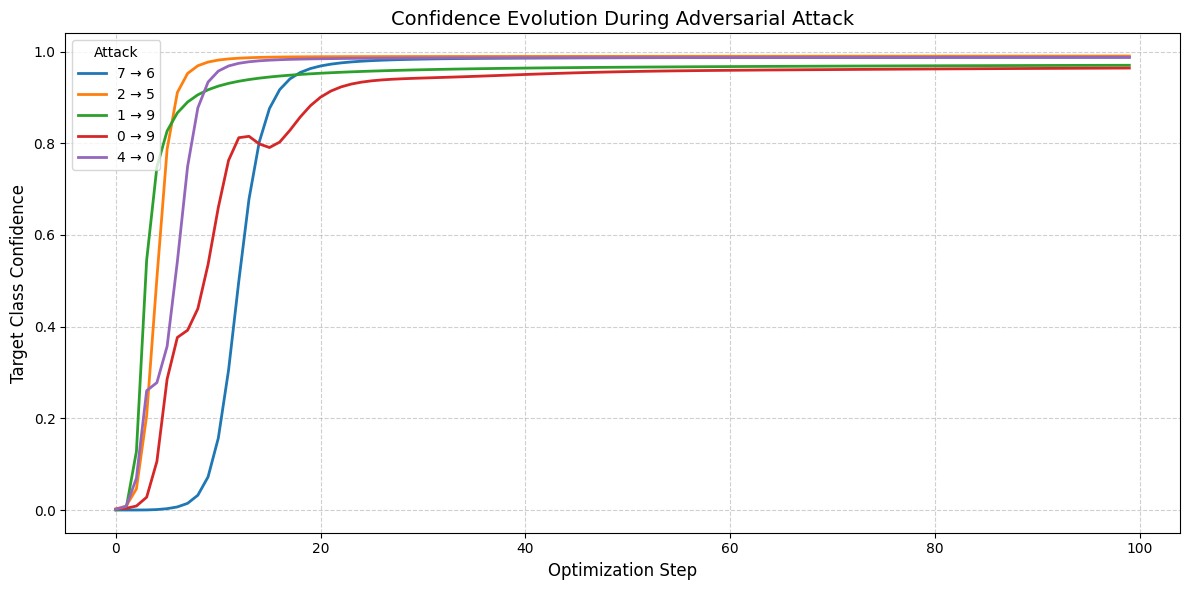

In [13]:
plt.figure(figsize=(12, 6))
for true_lbl, target_lbl, confs in confidence_histories:
    label = f"{true_lbl} → {target_lbl}"
    plt.plot(range(len(confs)), confs, label=label, linewidth=2)

plt.xlabel("Optimization Step", fontsize=12)
plt.ylabel("Target Class Confidence", fontsize=12)
plt.title("Confidence Evolution During Adversarial Attack", fontsize=14)
plt.legend(title="Attack", loc="upper left", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#**ANALYSIS**
This plot tracks the confidence LeNet-5 assigns to the target **wrong class** over 100 optimization steps. In all cases, the confidence rapidly increases. Some of them even reach 99% in under 20 steps. The curve shapes highlight that small, iterative noise updates can strongly shift the model’s belief even while preserving human legibility.

# **Changing lambda**

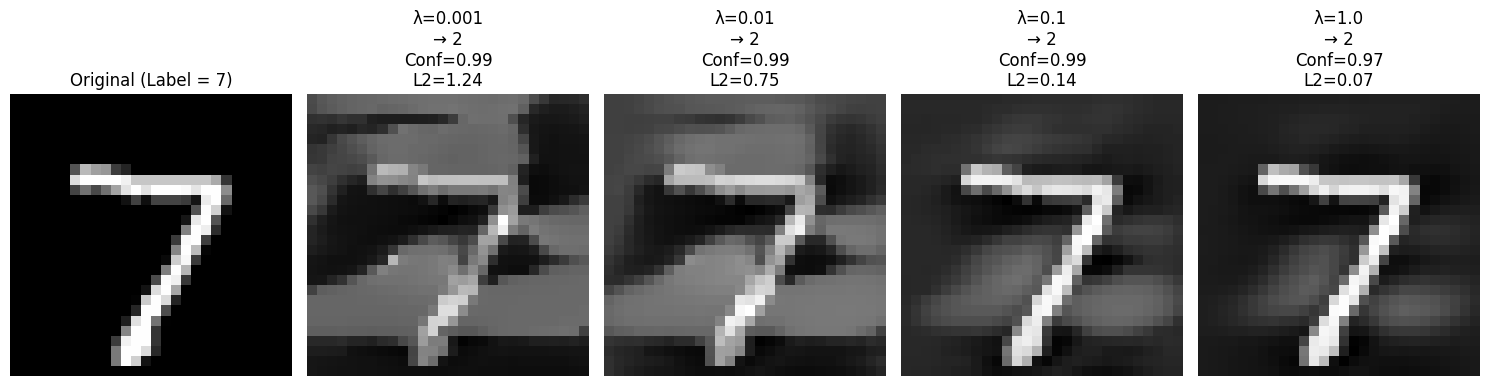

In [ ]:
target_class = 2
sample_img, label = next((img, lbl) for img, lbl in mnist if lbl == 7)
img = sample_img.unsqueeze(0)
img = img.to(device)
true_label = torch.tensor([label], device=device)
target_wrong = torch.tensor([target_class], device=device)

lambda_values = [0.001, 0.01, 0.1, 1.0]
results = []

for lam in lambda_values:
    delta = torch.zeros_like(img, requires_grad=True)
    optimizer = torch.optim.Adam([delta], lr=0.1)

    for _ in range(300):
        optimizer.zero_grad()
        logits = net(img + delta)
        loss = F.cross_entropy(logits, target_wrong) + lam * delta.pow(2).mean()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        pred = net(img + delta).argmax(dim=1).item()
        conf = F.softmax(net(img + delta), dim=1)[0, target_class].item()
        l2_norm = delta.pow(2).mean().item()

    results.append({
        'lambda': lam,
        'image': (img + delta).squeeze().cpu(),
        'prediction': pred,
        'confidence': conf,
        'l2': l2_norm
    })

fig, axes = plt.subplots(1, len(results)+1, figsize=(15, 4))
axes[0].imshow(img.squeeze().cpu(), cmap='gray')
axes[0].set_title(f"Original (Label = {label})")
axes[0].axis('off')

for i, res in enumerate(results):
    axes[i+1].imshow(res['image'].detach().numpy(), cmap='gray')
    axes[i+1].set_title(f"λ={res['lambda']}\n→ {res['prediction']}\nConf={res['confidence']:.2f}\nL2={res['l2']:.2f}")
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

# **ANALYSIS**
This experiment illustrates how varying the L2 regularization coefficient (λ) impacts adversarial image generation. All perturbed images are optimized to change the classification of the digit "7" to "2", while keeping the digit appearance relatively unchanged.

- Low λ (e.g., 0.001): The model confidently misclassifies the digit, but the noise is more noticeable (L2 norm = 1.24), resulting in visible artifacts.

- Moderate λ (e.g., 0.01 to 0.1): Maintains high confidence (0.99) while significantly reducing the perturbation magnitude.

- High λ (1.0): Further reduces the noise (L2 norm = 0.07), making the digit almost indistinguishable from the original, but slightly lowers the model’s confidence (0.97).

In conclusion, increasing λ improves visual fidelity (less noise), but may reduce attack confidence. Moderate λ values  offer an interesting equilibrium between effective and visually subtle adversarial examples.

